# EDA

# 1st step: let's see how many unique features do we have, their field types and also dataset size

In [400]:
import json
import os
from pathlib import Path

dataset = Path('/Users/layvvs/Desktop/HSE/Studying/year-project/downloaded_tracks')

meta_data = dataset/'metadata'
audio_data = dataset/'audio'

## Dataset size

In [401]:
meta_data_content = os.listdir(meta_data)
audio_data_content = os.listdir(audio_data)

meta_data_size = len(meta_data_content)
audio_data_size = len(audio_data_content)

print('Meta data size:', meta_data_size)
print('Audio data size:', audio_data_size)

Meta data size: 2001
Audio data size: 2001


## Fields and their types

In [402]:
from collections import Counter
import pandas as pd

fields_count = Counter()


def parse_field(field, content):
    if not isinstance(content, dict):
        return [(field, type(content).__name__)]
    result = []
    for subfield, subcontent in content.items():
        result.extend(parse_field(subfield, subcontent))
    return result


for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        fields = []
        for field, content in data.items():
            fields.extend(parse_field(field, content))
        fields_count.update(fields)


dataset_info = pd.DataFrame(
    [
        (field[0], field[1], field_count)
        for field, field_count in fields_count.items()
    ],
    columns=['field', 'type', 'count']
)
dataset_info

,field,type,count
0,id,str,2001
1,name,str,2001
2,duration,int,2001
3,artist_id,str,2001
4,artist_name,str,2001
5,album_id,str,2001
6,album_name,str,2001
7,releasedate,str,2001
8,waveform,str,2000
9,vocalinstrumental,str,2001


### Intermediate conclusions
At this point we've `23` unique features (we'll take `avgnote` as `float`).

Now we've to decide how add audio, waveform and list to dataframe.

I think i'll create another file for the peaks values and add the file path to the table for the audio as well.

For the categorical features (list, str) we can use type casting (many string types in data originally are int or float), encodings and text embeddings.

# 2nd step: data preprocessing. Type casting, encoding and embeddings 

## Let's look at the unique values of categorical data

Field artist_id, unique values 669
Field album_id, unique values 1065
Field vocalinstrumental, unique values 3
Field lang, unique values 9
Field gender, unique values 4
Field acousticelectric, unique values 3
Field speed, unique values 6
Field genres, unique values 140
Field instruments, unique values 61
Field vartags, unique values 463


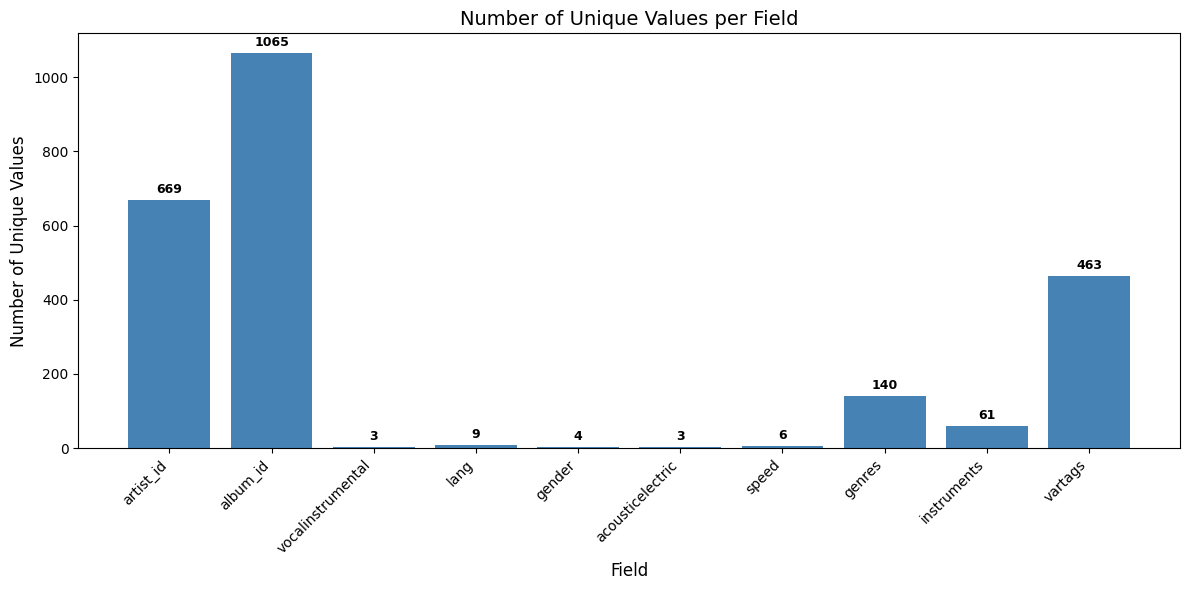

In [403]:
from collections import defaultdict
import matplotlib.pyplot as plt

skip_fileds = ['id', 'artist_name', 'album_name', 'releasedate', 'waveform', 'name']

unique_values = defaultdict(set)

def parse_field(field, content):
    if isinstance(content, float) or isinstance(content, int) or field in skip_fileds:
        return
    if isinstance(content, list):
        unique_values[field].update(content)
        return
    if isinstance(content, str):
        unique_values[field].update([content])
        return
    for subfield, subcontent in content.items():
        parse_field(subfield, subcontent)

for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        for field, content in data.items():
            parse_field(field, content)

field_counts = {field: len(values) for field, values in unique_values.items()}

for field, content in field_counts.items():
    print(f'Field {field}, unique values {content}')

fields, counts = zip(*field_counts.items())

plt.figure(figsize=(12, 6))
bars = plt.bar(fields, counts, color='steelblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Number of Unique Values per Field', fontsize=14)
plt.xlabel('Field', fontsize=12)
plt.ylabel('Number of Unique Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Intermediate conclusions
* We can see that we've `669` *unique artists*, `1065` *unique albums* and `2001` *songs* in current dataset.

* We can use different techniques of encoding for fields `vocalinstrumental`, `lang`, `gender`, `acousticelectric`, `speed` because of small amount of unique values.

* We can split field `releasedate` on year/mont/day columns.

* I think we should use an embedding model for fields `genres`, `instuments`, `vartags`.

We can also drop fields like song/artist/album name, id-fields for model training, but rn i'm not sure about this. We'll see

In [404]:
for field, values in unique_values.items():
    print(f'Field {field}, unique values {values}')

Field artist_id, unique values {'498715', '509386', '8303', '457603', '357396', '358087', '496541', '421686', '378695', '348433', '366801', '428294', '367346', '454156', '340291', '345816', '367151', '338779', '354307', '480445', '462184', '339724', '344760', '522305', '344688', '1333', '5374', '467550', '487051', '353387', '467034', '340121', '337983', '426658', '359156', '490381', '375106', '2210', '511213', '542401', '437999', '353120', '351372', '540036', '533079', '6615', '493564', '551902', '442010', '361689', '499734', '2020', '490453', '495807', '475967', '2208', '338582', '506990', '386200', '474132', '376782', '337294', '371777', '504167', '370143', '357466', '341681', '491380', '349911', '473685', '492967', '362044', '1301', '506072', '517272', '503091', '436631', '457964', '421017', '339779', '340555', '370748', '343172', '519486', '5611', '456653', '347881', '498188', '163', '421034', '345952', '7805', '340553', '358789', '366820', '342507', '378219', '352814', '430396', '

## Data encoding

Let's apply *one-hot encoding* for `lang`, `gender`, `acousticelectric` and *label encoding* for `speed`

In [405]:
all_data = []

for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data = json.load(f)
        if isinstance(data, dict):
            all_data.append(data)


df = pd.json_normalize(all_data)

df.reset_index(drop=True, inplace=True)

original_data = df.copy(deep=True)

df = df.apply(pd.to_numeric, errors='ignore')

df['releasedate'] = df['releasedate'].apply(pd.to_datetime)

df['releasedate_year'] = df['releasedate'].dt.year
df['releasedate_month'] = df['releasedate'].dt.month
df['releasedate_day'] = df['releasedate'].dt.day

df = df.drop('releasedate', axis=1)

df['track_speed_low'] = df['musicinfo.speed'].isin(['low', 'verylow']).astype(int)
df['track_speed_medium'] = (df['musicinfo.speed'] == 'medium').astype(int)
df['track_speed_high'] = df['musicinfo.speed'].isin(['high', 'veryhigh']).astype(int)
df['track_speed_not_specified'] = (df['musicinfo.speed'] == '').astype(int)

df = df.drop('musicinfo.speed', axis=1)

df['artist_gender_male'] = (df['musicinfo.gender'] == 'male').astype(int)
df['artist_gender_female'] = (df['musicinfo.gender'] == 'female').astype(int)
df['artist_gender_neutral'] = (df['musicinfo.gender'] == 'neutral').astype(int)
df['artist_gender_not_specified'] = (df['musicinfo.gender'] == '').astype(int)

df = df.drop('musicinfo.gender', axis=1)

df['acoustic'] = (df['musicinfo.acousticelectric'] == 'acoustic').astype(int)
df['electric'] = (df['musicinfo.acousticelectric'] == 'electric').astype(int)
df['acousticelectric_not_specified'] = (df['musicinfo.acousticelectric'] == '').astype(int)

df = df.drop('musicinfo.acousticelectric', axis=1)

df['vocal'] = (df['musicinfo.vocalinstrumental'] == 'vocal').astype(int)
df['instrumental'] = (df['musicinfo.vocalinstrumental'] == 'instrumental').astype(int)
df['vocalinstrumental'] = (df['musicinfo.vocalinstrumental'] == '').astype(int)

df = df.drop('musicinfo.vocalinstrumental', axis=1)

df.head()


/var/folders/3t/gyxj9s512yx6klv5c576ykyc0000gn/T/ipykernel_70688/631254407.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,id,name,duration,artist_id,artist_name,album_id,album_name,waveform,musicinfo.lang,musicinfo.tags.genres,...,artist_gender_male,artist_gender_female,artist_gender_neutral,artist_gender_not_specified,acoustic,electric,acousticelectric_not_specified,vocal,instrumental,vocalinstrumental
0,1093617,Love Too Serious,264,378695,Lilly Wolf,130349.0,Play Loud,"{""peaks"":[95,43,79,65,14,7,28,86,44,65,57,20,2...",en,"[pop, dance, synthpop]",...,0,1,0,0,0,1,0,1,0,0
1,1466886,Girls Like You,198,498715,The Spin Wires,170073.0,The Spin Wires EP,"{""peaks"":[71,71,69,69,88,84,62,66,84,70,48,84,...",en,"[rock, alternativerock, indierock]",...,1,0,0,0,0,0,1,1,0,0
2,159927,Put That Boy Away,234,339246,Dan Bryk,23027.0,Discount Store,"{""peaks"":[16,90,38,36,89,27,9,20,29,98,83,31,9...",,[pop],...,1,0,0,0,0,0,1,1,0,0
3,1319749,Epic Music,110,487189,Aliaksei Yukhnevich,263838.0,Epic Music,"{""peaks"":[0,0,1,2,3,4,6,8,11,12,12,14,16,15,18...",,"[filmscore, symphonic]",...,0,0,0,1,0,0,1,0,1,0
4,248375,Shine,170,344760,Circa Vitae,35849.0,CIRCA VITAE ep,"{""peaks"":[7,6,6,6,5,4,4,4,5,6,5,5,8,7,5,8,7,4,...",en,"[rock, indierock, indie]",...,1,0,0,0,0,0,1,1,0,0


In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2001 non-null   int64  
 1   name                            2001 non-null   object 
 2   duration                        2001 non-null   int64  
 3   artist_id                       2001 non-null   int64  
 4   artist_name                     2001 non-null   object 
 5   album_id                        1997 non-null   float64
 6   album_name                      2001 non-null   object 
 7   waveform                        2000 non-null   object 
 8   musicinfo.lang                  2001 non-null   object 
 9   musicinfo.tags.genres           2001 non-null   object 
 10  musicinfo.tags.instruments      2001 non-null   object 
 11  musicinfo.tags.vartags          2001 non-null   object 
 12  stats.rate_downloads_total      20

Let's find top-10 most common values for genre, vartags and instruments.

In [407]:
vartags_counter =  Counter()
genres_counter = Counter()
instruments_counter = Counter()

for row in df['musicinfo.tags.vartags']:
    vartags_counter.update(row)

for row in df['musicinfo.tags.genres']:
    genres_counter.update(row)

for row in df['musicinfo.tags.instruments']:
    instruments_counter.update(row)

vartags_counter_mc = vartags_counter.most_common(10) 
genres_counter_mc = genres_counter.most_common(10)
instruments_counter = instruments_counter.most_common(10)

print(vartags_counter_mc)
print(genres_counter_mc)
print(instruments_counter)

[('voice', 1147), ('vocal', 1051), ('acoustic', 573), ('neutral', 238), ('energetic', 229), ('peaceful', 229), ('happy', 217), ('love', 149), ('upbeat', 101), ('soft', 95)]
[('pop', 615), ('rock', 382), ('electronic', 356), ('jazz', 257), ('indie', 151), ('folk', 144), ('chillout', 102), ('ambient', 98), ('dance', 97), ('singersongwriter', 92)]
[('strings', 309), ('piano', 293), ('synthesizer', 276), ('guitar', 198), ('drums', 188), ('electricguitar', 185), ('electroamplified', 99), ('bass', 73), ('acousticguitar', 53), ('saxophone', 45)]


Now we know that the most popular vartag is 'voice', the most popular genre is 'pop' and the most popular instrument is 'strings'

Let's use this top-10 for OHE instead of adding 650+ columns.

There was a suggestion to use TF-IDF (or bm25) for columns with array datatype to chose the most valuable termins but i think it won't work because arrays only have unique words instead of sentences so OHE fits better i think

Let's also drop waveform feature because we don't know how it was produced and we will use it later as audio feature and encode language as well

In [408]:
df = df.drop('waveform', axis=1)

In [409]:
top_vartags = [tag for tag, _ in vartags_counter_mc]

for tag in top_vartags:
    df['vartag_' + tag] = df['musicinfo.tags.vartags'].apply(
        lambda tags: int(isinstance(tags, list) and tag in tags)
    )

df['other_vartag'] = df['musicinfo.tags.vartags'].apply(
    lambda tags: int(
        not isinstance(tags, list) or
        len(tags) == 0 or
        any(t not in top_vartags for t in tags)
    )
)

df = df.drop('musicinfo.tags.vartags', axis=1)


top_genres = [genre for genre, _ in genres_counter_mc]

for genre in top_genres:
    df['genre_' + genre] = df['musicinfo.tags.genres'].apply(
        lambda genres: int(isinstance(genres, list) and genre in genres)
    )

df['other_genres'] = df['musicinfo.tags.genres'].apply(
    lambda genres: int(
        not isinstance(genres, list) or
        len(genres) == 0 or
        any(t not in top_genres for t in genres)
    )
)

df = df.drop('musicinfo.tags.genres', axis=1)


top_instruments = [instrument for instrument, _ in instruments_counter]

for instrument in top_instruments:
    df['instrument_' + instrument] = df['musicinfo.tags.instruments'].apply(
        lambda instruments: int(isinstance(instruments, list) and instrument in instruments)
    )

df['other_instruments'] = df['musicinfo.tags.instruments'].apply(
    lambda instruments: int(
        not isinstance(instruments, list) or
        len(instruments) == 0 or
        any(t not in top_instruments for t in instruments)
    )
)

df = df.drop('musicinfo.tags.instruments', axis=1)

languages = list(df['musicinfo.lang'].unique())

for language in languages:
    df['lang_' + language] = (df['musicinfo.lang'] == language).astype(int)

df['lang_undefined'] = df['lang_']

df = df.drop('musicinfo.lang', axis=1)
df = df.drop('lang_', axis=1)


df

,id,name,duration,artist_id,artist_name,album_id,album_name,stats.rate_downloads_total,stats.rate_listened_total,stats.playlisted,...,other_instruments,lang_en,lang_es,lang_fr,lang_it,lang_de,lang_zh,lang_id,lang_pt,lang_undefined
0,1093617,Love Too Serious,264,378695,Lilly Wolf,130349.0,Play Loud,386816,1659776,307,...,0,1,0,0,0,0,0,0,0,0
1,1466886,Girls Like You,198,498715,The Spin Wires,170073.0,The Spin Wires EP,147168,1153129,947,...,0,1,0,0,0,0,0,0,0,0
2,159927,Put That Boy Away,234,339246,Dan Bryk,23027.0,Discount Store,6878,188773,222,...,1,0,0,0,0,0,0,0,0,1
3,1319749,Epic Music,110,487189,Aliaksei Yukhnevich,263838.0,Epic Music,97509,374699,1804,...,1,0,0,0,0,0,0,0,0,1
4,248375,Shine,170,344760,Circa Vitae,35849.0,CIRCA VITAE ep,22626,1471358,669,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,520984,Big Plans,189,357359,Kellee Maize,60891.0,Aligned Archetype (2010),14701,388722,381,...,1,0,0,0,0,0,0,0,0,1
1997,22281,Sister Rosa,217,2935,Slim,3100.0,Interstate Medicine,8917,152812,1427,...,1,1,0,0,0,0,0,0,0,0
1998,849002,Figured Out,274,371777,Neon NiteClub,99194.0,One Week In December,7100,192823,36,...,1,0,0,0,0,0,0,0,0,1
1999,162025,Go,226,7872,Josh Woodward,23755.0,The Simple Life,172819,1778843,2208,...,0,1,0,0,0,0,0,0,0,0


In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2001 non-null   int64  
 1   name                            2001 non-null   object 
 2   duration                        2001 non-null   int64  
 3   artist_id                       2001 non-null   int64  
 4   artist_name                     2001 non-null   object 
 5   album_id                        1997 non-null   float64
 6   album_name                      2001 non-null   object 
 7   stats.rate_downloads_total      2001 non-null   int64  
 8   stats.rate_listened_total       2001 non-null   int64  
 9   stats.playlisted                2001 non-null   int64  
 10  stats.favorited                 2001 non-null   int64  
 11  stats.likes                     2001 non-null   int64  
 12  stats.dislikes                  20

We have got rid of categorical data

In [411]:
df.describe()

,id,duration,artist_id,album_id,stats.rate_downloads_total,stats.rate_listened_total,stats.playlisted,stats.favorited,stats.likes,stats.dislikes,...,other_instruments,lang_en,lang_es,lang_fr,lang_it,lang_de,lang_zh,lang_id,lang_pt,lang_undefined
count,2.001000e+03,2001.000000,2001.000000,1997.000000,2.001000e+03,2.001000e+03,2001.000000,2001.000000,2001.000000,2001.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,7.792772e+05,235.921039,301339.413293,112266.991487,1.354119e+05,6.538478e+05,1058.080960,689.734633,11.339330,0.803598,...,0.540230,0.380310,0.013493,0.015992,0.003498,0.000500,0.000500,0.000500,0.001000,0.584208
std,5.796639e+05,75.869024,185867.343915,110144.345784,6.322171e+05,9.908983e+05,1387.156057,970.515669,29.045177,2.016657,...,0.498504,0.485584,0.115403,0.125476,0.059057,0.022355,0.022355,0.022355,0.031607,0.492981
min,1.680000e+02,4.000000,5.000000,24.000000,2.076000e+03,1.178400e+04,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.820660e+05,191.000000,7872.000000,27332.000000,1.440400e+04,2.450090e+05,206.000000,111.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.854340e+05,225.000000,355753.000000,92133.000000,3.274500e+04,4.450410e+05,522.000000,304.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.210694e+06,268.000000,441585.000000,145734.000000,8.706100e+04,7.583100e+05,1398.000000,843.000000,10.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.203626e+06,1196.000000,587816.000000,581062.000000,1.671905e+07,2.484764e+07,10167.000000,6221.000000,471.000000,27.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's log and normalize data before using T-SNE

In [412]:
numeric_features = ['duration', 'stats.rate_downloads_total', 'stats.rate_listened_total', 'stats.playlisted', 'stats.favorited', 'stats.likes', 'stats.dislikes', 'stats.avgnote'] 

skew_vals = df[numeric_features].skew(numeric_only=True)
print('skew_vals\n', skew_vals)
print()
print('describe\n', df[numeric_features].describe())


skew_vals
 duration                       2.749444
stats.rate_downloads_total    17.785077
stats.rate_listened_total     11.835666
stats.playlisted               2.568427
stats.favorited                2.607267
stats.likes                    7.832474
stats.dislikes                 5.336555
stats.avgnote                 -2.655964
dtype: float64

describe
           duration  stats.rate_downloads_total  stats.rate_listened_total  \
count  2001.000000                2.001000e+03               2.001000e+03   
mean    235.921039                1.354119e+05               6.538478e+05   
std      75.869024                6.322171e+05               9.908983e+05   
min       4.000000                2.076000e+03               1.178400e+04   
25%     191.000000                1.440400e+04               2.450090e+05   
50%     225.000000                3.274500e+04               4.450410e+05   
75%     268.000000                8.706100e+04               7.583100e+05   
max    1196.000000         

We can see that cols 'duration', 'stats.rate_downloads_total', 'stats.rate_listened_total', 'stats.playlisted', 'stats.favorited', 'stats.likes', 'stats.dislikes' are skewed so let's log them

In [413]:
import numpy as np

numeric_features.remove('stats.avgnote')

df[numeric_features] = df[numeric_features].apply(np.log1p)

skew_vals = df[numeric_features].skew(numeric_only=True)
print('skew_vals\n', skew_vals)
print()
print('describe\n', df[numeric_features].describe())

skew_vals
 duration                     -0.896026
stats.rate_downloads_total    0.758248
stats.rate_listened_total    -0.515803
stats.playlisted             -0.113718
stats.favorited              -0.097131
stats.likes                   0.505153
stats.dislikes                1.810114
dtype: float64

describe
           duration  stats.rate_downloads_total  stats.rate_listened_total  \
count  2001.000000                 2001.000000                2001.000000   
mean      5.423637                   10.558947                  12.942969   
std       0.300417                    1.323392                   0.972229   
min       1.609438                    7.638680                   9.374583   
25%       5.257495                    9.575331                  12.409054   
50%       5.420535                   10.396536                  13.005924   
75%       5.594711                   11.374376                  13.538849   
max       7.087574                   16.632059                  17.028273 

Now let's standartize data

In [414]:
from sklearn.preprocessing import StandardScaler

numeric_features.append('stats.avgnote')

df[numeric_features] = StandardScaler().fit_transform(df[numeric_features])

df.head()

,id,name,duration,artist_id,artist_name,album_id,album_name,stats.rate_downloads_total,stats.rate_listened_total,stats.playlisted,...,other_instruments,lang_en,lang_es,lang_fr,lang_it,lang_de,lang_zh,lang_id,lang_pt,lang_undefined
0,1093617,Love Too Serious,0.519716,378695,Lilly Wolf,130349.0,Play Loud,1.743502,1.418976,-0.412227,...,0,1,0,0,0,0,0,0,0,0
1,1466886,Girls Like You,-0.433945,498715,The Spin Wires,170073.0,The Spin Wires EP,1.013097,1.044276,0.481341,...,0,1,0,0,0,0,0,0,0,0
2,159927,Put That Boy Away,0.119692,339246,Dan Bryk,23027.0,Discount Store,-1.302070,-0.817566,-0.668894,...,1,0,0,0,0,0,0,0,0,1
3,1319749,Epic Music,-2.377642,487189,Aliaksei Yukhnevich,263838.0,Epic Music,0.701981,-0.112232,0.993168,...,1,0,0,0,0,0,0,0,0,1
4,248375,Shine,-0.938840,344760,Circa Vitae,35849.0,CIRCA VITAE ep,-0.402134,1.295007,0.205481,...,0,1,0,0,0,0,0,0,0,0


Now we can use PCA + T-SNE

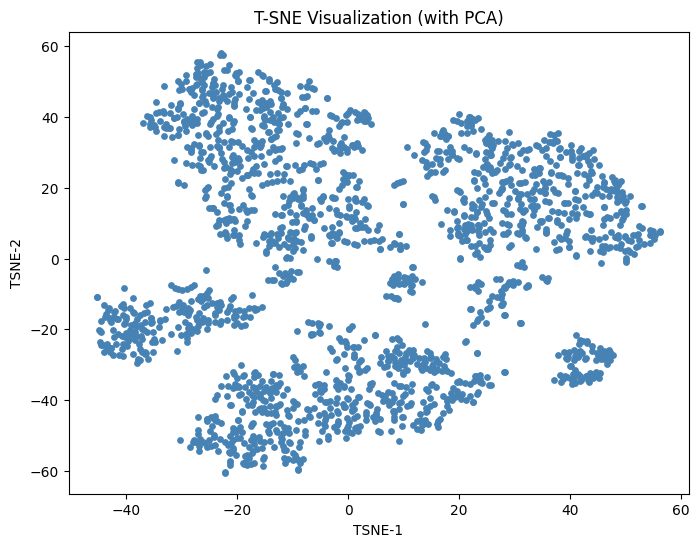

In [415]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = df.drop(columns=[
    'id', 'artist_id', 'artist_name', 'album_id', 'album_name', 
    'name', 'releasedate_year', 'releasedate_month', 'releasedate_day'
], errors='ignore', axis=1)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)
X_tsne_pca = tsne.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], s=15, color='steelblue')

plt.title("T-SNE Visualization (with PCA)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


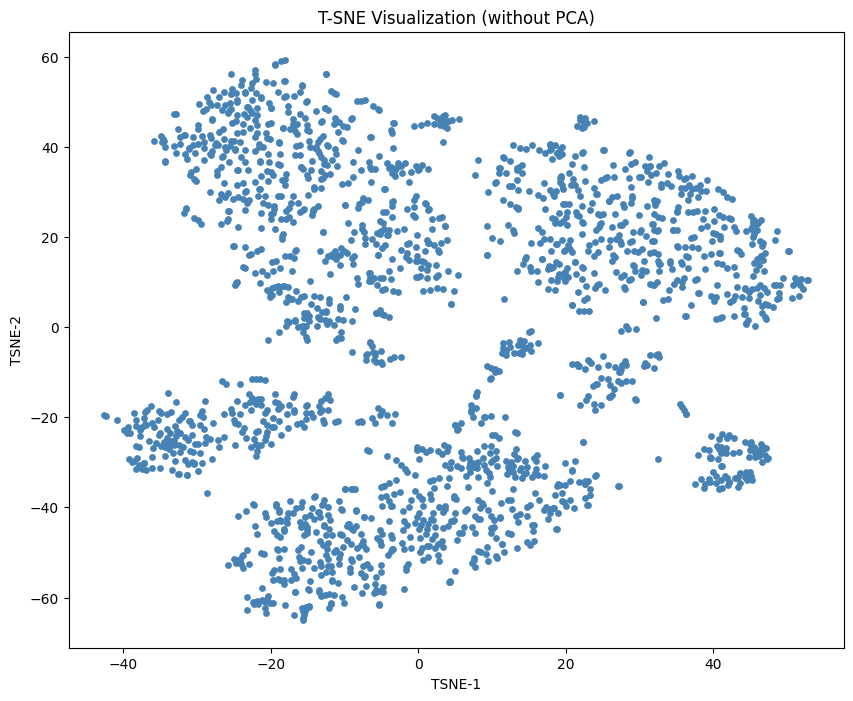

In [416]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = df.drop(columns=[
    'id', 'artist_id', 'artist_name', 'album_id', 'album_name', 
    'name', 'releasedate_year', 'releasedate_month', 'releasedate_day'
], errors='ignore', axis=1)


tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)
X_tsne_no_pca = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_no_pca[:, 0], X_tsne_no_pca[:, 1], s=15, color='steelblue')

plt.title("T-SNE Visualization (without PCA)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


There is a difference in density between these approaches. Let's use t-SNE with PCA

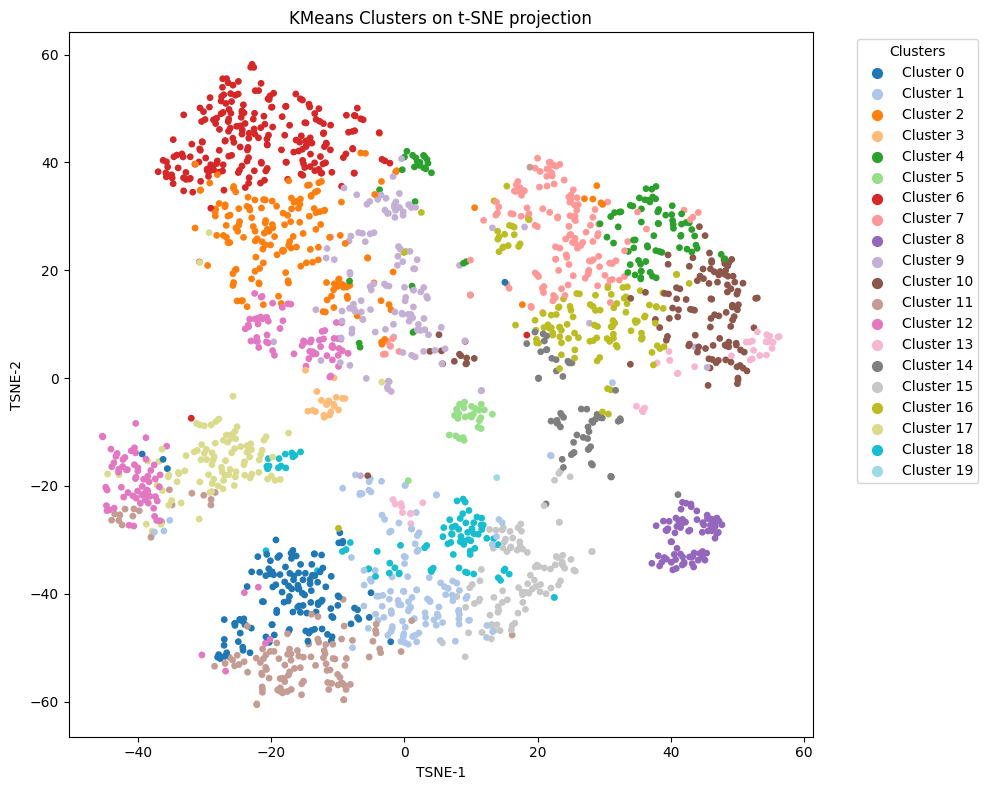

In [417]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], c=clusters, cmap='tab20', s=15)

handles = []
labels = []
for i in np.unique(clusters):
    handles.append(plt.scatter([], [], color=scatter.cmap(scatter.norm(i)), s=50))
    labels.append(f'Cluster {i}')

plt.legend(handles=handles, labels=labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("KMeans Clusters on t-SNE projection")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


In [418]:
original_data['cluster'] = clusters
print(original_data.groupby('cluster')['artist_name'].apply(lambda x: x.value_counts().head(3)))

cluster                                
0        HiGhMaS                           10
         SONIC MYSTERY                      8
         Oleg O. Kachanko                   8
1        Antony Raijekov                    7
         Revolution Void                    6
         Professor Kliq                     6
2        David Krystal                     11
         Fresh Body Shop                    8
         Ed Shulzhevsky                     4
3        Proyecto G                         2
         Hasenchat                          2
         MR.PEARSON                         2
4        Jonathan Dimmel                   15
         Backnbloom                         5
         Ralf G. (Ralf Gründer)             4
5        Brad Sucks                        14
         Diablo Swing Orchestra             7
         Silence is Sexy                    3
6        Square a Saw                       9
         The Devil Music Co.                8
         The.madpix.project             

In [419]:
genre_counts_per_cluster = (
    original_data[['cluster', 'musicinfo.tags.genres']]
    .explode('musicinfo.tags.genres')                   
    .groupby('cluster')['musicinfo.tags.genres']
    .apply(lambda x: x.value_counts().head(3)) 
)

print(genre_counts_per_cluster)

cluster                   
0        electronic            40
         jazz                  35
         ambient               22
1        electronic            56
         jazz                  18
         chillout              16
2        pop                   78
         rock                  40
         singersongwriter      29
3        hiphop                 4
         pop                    4
         electronic             4
4        pop                   72
         rock                  37
         indie                 14
5        rock                  20
         funk                   2
         reggae                 1
6        pop                  118
         rock                  36
         electronic            34
7        pop                   58
         rock                  41
         jazz                  34
8        rock                  19
         metal                 18
         electronic            11
9        pop                   63
         rock        

I think that the clusters separated well by the genres according to the table and picture above. Clusters with sufficient number of intersected genres are mostly laying near with each other. For example clusters 2 and 6 has a lot of pop genre -> they are placed near but clusters 6 and 8 are too far from each other because cluster 6 is more about pop genre and not rock/electronic 

In [420]:
genre_counts_per_cluster = (
    original_data[['cluster', 'musicinfo.tags.instruments']]
    .explode('musicinfo.tags.instruments')                   
    .groupby('cluster')['musicinfo.tags.instruments']
    .apply(lambda x: x.value_counts().head(3)) 
)

print(genre_counts_per_cluster)

cluster                  
0        synthesizer         24
         piano               19
         electroamplified    17
1        piano               22
         synthesizer         18
         strings             14
2        strings             33
         synthesizer         33
         guitar              24
3        piano                1
         sampler              1
         horn                 1
4        electricguitar      31
         drums               20
         synthesizer         15
5        guitar               2
         synthesizer          1
6        synthesizer         57
         guitar              45
         strings             41
7        strings             18
         electricguitar      15
         guitar              13
8        synthesizer          5
         drums                3
         piano                2
9        guitar              11
         drums               11
         strings             11
10       synthesizer         25
         drums

We can also see the same picture looking at instruments

In [427]:
original_data.groupby('cluster')[[
    'stats.rate_downloads_total',
    'stats.rate_listened_total',
    'stats.playlisted',
    'stats.favorited',
    'stats.likes',
    'stats.dislikes',
    'stats.avgnote'
]].mean().astype(int)

,stats.rate_downloads_total,stats.rate_listened_total,stats.playlisted,stats.favorited,stats.likes,stats.dislikes,stats.avgnote
cluster,,,,,,,
0,25762,524060,318,170,4,0,7
1,72582,616758,1714,1065,22,1,7
2,29971,356226,176,111,0,0,8
3,1232841,2153575,98,52,4,2,1
4,142372,1184623,168,85,6,0,7
5,64014,273066,3870,2575,16,0,8
6,206498,843595,1163,775,0,0,8
7,12955,384525,267,143,3,0,7
8,19764,81033,2161,1644,3,0,0
